In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [3]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label=filename.split('_')[-1]
        label=label.split('.')[0]
        label=label.lower()
        labels.append(label)
print("Dataset Successfully Loaded")

df=pd.DataFrame()
df["speech"]=paths
df["label"]=labels


Dataset Successfully Loaded


In [8]:
df=pd.DataFrame()
df["speech"]=paths
df["label"]=labels
df.tail()

,speech,label
5595,/kaggle/input/toronto-emotional-speech-set-tes...,ps
5596,/kaggle/input/toronto-emotional-speech-set-tes...,ps
5597,/kaggle/input/toronto-emotional-speech-set-tes...,ps
5598,/kaggle/input/toronto-emotional-speech-set-tes...,ps
5599,/kaggle/input/toronto-emotional-speech-set-tes...,ps


In [9]:
df["label"].value_counts()

label
fear       800
angry      800
disgust    800
neutral    800
sad        800
ps         800
happy      800
Name: count, dtype: int64

In [10]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

In [5]:
def spectrogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,4))
    plt.title(emotion)
    librosa.display.specshow(xdb,sr=sr, x_axis='time', y_axis='hz')

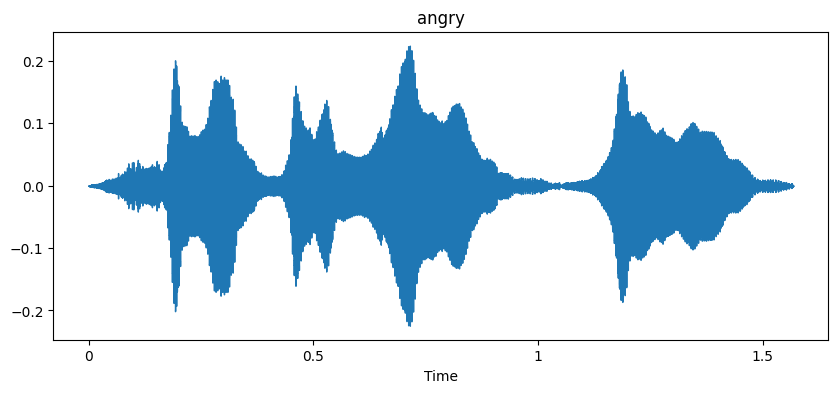

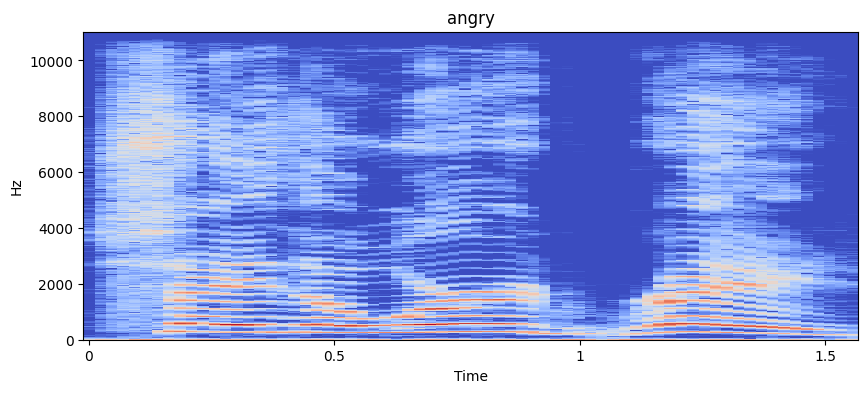

In [14]:
emotion='angry'
path=np.array(df['speech'][df['label']==emotion])[0]
data, sr= librosa.load(path)
waveplot(data,sr,emotion)
spectrogram(data,sr,emotion)
Audio(path)

In [15]:
def extract_mfcc(filename):
    y,sr=librosa.load(filename, duration=3, offset=0.5)
    mfcc=np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [16]:
extract_mfcc(df['speech'][0])

array([-285.73727  ,   85.78295  ,   -2.1689112,   22.125532 ,
        -14.757396 ,   11.051346 ,   12.41245  ,   -3.000262 ,
          1.0844992,   11.078272 ,  -17.419659 ,   -8.093213 ,
          6.5879726,   -4.2209525,   -9.15508  ,    3.5214796,
        -13.186381 ,   14.078853 ,   19.66973  ,   22.725618 ,
         32.574635 ,   16.325033 ,   -3.8427296,    0.8962965,
        -11.239263 ,    6.653462 ,   -2.5883694,   -7.714016 ,
        -10.941657 ,   -2.4007545,   -5.2812867,    4.2711573,
        -11.202217 ,   -9.024621 ,   -3.6669843,    4.869744 ,
         -1.6027982,    2.5600514,   11.454374 ,   11.233449 ],
      dtype=float32)

In [17]:
X_mfcc=df['speech'].apply(lambda x: extract_mfcc(x))

In [18]:
X_mfcc

0       [-285.73727, 85.78295, -2.1689112, 22.125532, ...
1       [-348.34332, 35.193233, -3.8413274, 14.658876,...
2       [-340.11435, 53.79644, -14.267782, 20.884027, ...
3       [-306.63422, 21.259705, -4.4110823, 6.4871554,...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
5595    [-374.3952, 60.864998, 0.025058484, 8.431059, ...
5596    [-313.96478, 39.847843, -5.6493053, -3.8675754...
5597    [-357.54883, 77.88606, -15.224756, 2.1946328, ...
5598    [-353.1474, 101.6839, -14.175897, -12.037376, ...
5599    [-389.4595, 54.042767, 1.3469975, -1.4258981, ...
Name: speech, Length: 5600, dtype: object

In [19]:
X= [x for x in X_mfcc]
X=np.array(X)
X.shape

(5600, 40)

In [20]:
X=np.expand_dims(X,-1)
X.shape

(5600, 40, 1)

In [22]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
y=enc.fit_transform(df[['label']])

In [23]:
y=y.toarray()

In [24]:
y.shape

(5600, 7)

**CNN Model**

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

2025-05-20 06:55:00.457092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747724100.681624      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747724100.742270      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
model = Sequential()

# Conv Layer 1
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(40, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Conv Layer 2
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 classes

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 17, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,639 (647.03 KB)

 Trainable params: 165,255 (645.53 KB)

 Non-trainable params: 384 (1.50 KB)

In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6607 - loss: 0.9676 - val_accuracy: 0.9652 - val_loss: 0.1494
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9607 - loss: 0.1208 - val_accuracy: 0.9937 - val_loss: 0.0249
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9652 - loss: 0.0982 - val_accuracy: 0.9937 - val_loss: 0.0134
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9841 - loss: 0.0502 - val_accuracy: 0.9982 - val_loss: 0.0074
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9857 - loss: 0.0431 - val_accuracy: 0.9991 - val_loss: 0.0047
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9912 - loss: 0.0259 - val_accuracy: 0.9991 - val_loss: 0.0057
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9886 - loss: 0.0357 - val_accuracy: 0.9982 - val_loss: 0.0043
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9914 - loss: 0.0237 - val_accuracy: 1

In [32]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.3773e-04
Test Accuracy: 100.00%


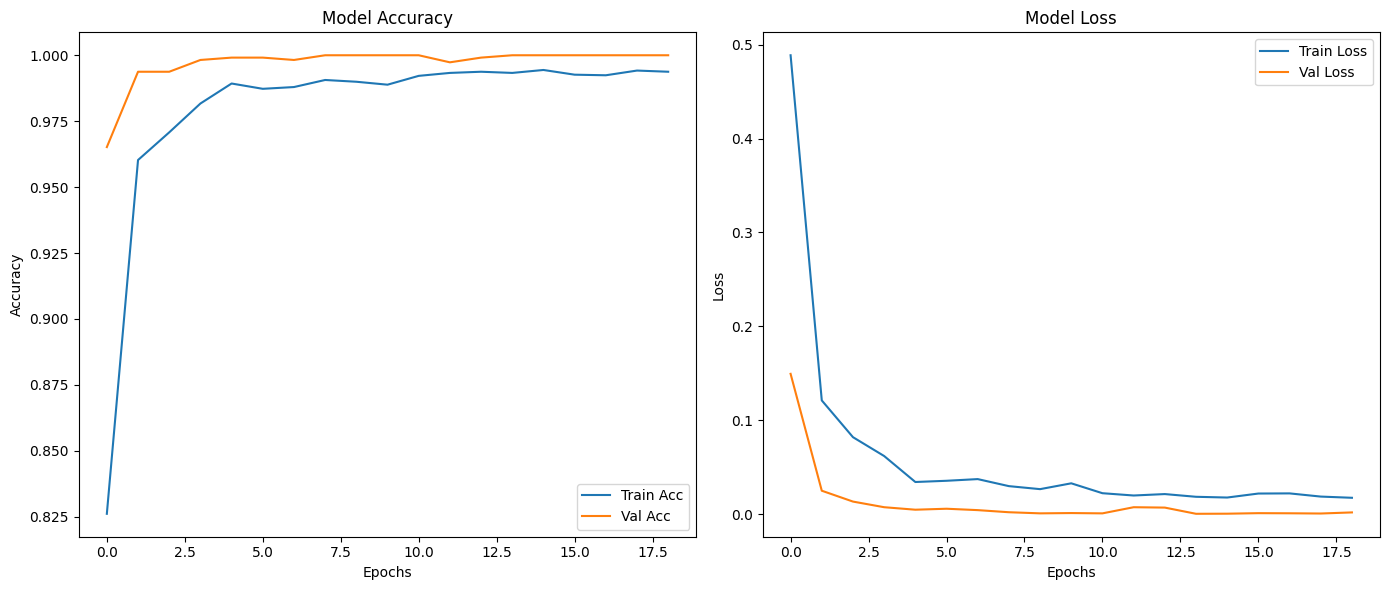

In [33]:
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       160
           2       1.00      1.00      1.00       160
           3       1.00      1.00      1.00       160
           4       1.00      1.00      1.00       160
           5       1.00      1.00      1.00       160
           6       1.00      1.00      1.00       160

    accuracy                           1.00      1120
   macro avg       1.00      1.00      1.00      1120
weighted avg       1.00      1.00      1.00      1120



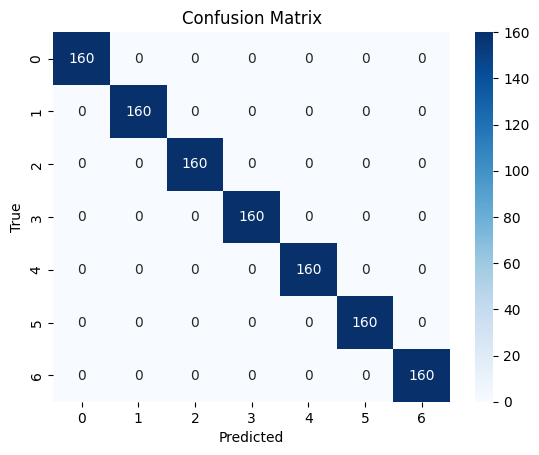

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [37]:
model.save("/kaggle/working/emotional.h5")